In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.stats
import tensorflow_probability as tfp
import tensorflow as tf
import seaborn as sns

2023-07-06 14:06:48.116370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
import torch
from torch.utils.data import  TensorDataset
dataset_path = ('../data/' + 'YACHT' + '.pth')
print('Loading dataset from %s' % dataset_path)
dataset = TensorDataset(*torch.load(dataset_path))
X, Y = dataset.tensors
X, Y = X.numpy(), Y.numpy()
X = X[0:10]
Y = Y[0:10]
print(X.shape)
inputs = torch.tensor(X, dtype=torch.float64)
targets = torch.tensor(Y, dtype=torch.float64)
torch.save([inputs, targets], 'toy_debug' + '.pth')

Loading dataset from ../data/YACHT.pth
(10, 6)
[0.0000000e+00 1.4901161e-08 3.7252903e-09 7.4505806e-09 0.0000000e+00
 7.1252531e-01]


/var/folders/48/1_svc68j0_b2js686ls_zqhh0000gn/T/ipykernel_1119/174114407.py:12: RuntimeWarning: invalid value encountered in true_divide
  X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)


In [2]:
n = 3
n_samples = 10000
size = int(n*(n+1)/2)
step_size = 0.1
V = np.random.rand(n)#np.eye(n)
K = 3

# Matrix Cookbook formula

In [23]:
n = 5
P = np.random.rand(5,5)
P = P @ P.T
U = scipy.linalg.cholesky(P, lower=False)

In [195]:
"""
def single_entry(n,i,j):
    J = np.zeros((n,n))
    J[i,j] = 1
    return J
def det_jacobian(n, P, L, Li):
    D = np.zeros((n*n,n*n))
    k = p = 0
    for i in range(0,n):
        for j in range(0,n):
            d = P @ Li @ single_entry(n,i,j) + single_entry(n,j,i) @ Li.T @ P
            D[p:p+n,k:k+n] = d
            k += n
        p += n
        k = 0
    return np.abs(np.linalg.det(D))
"""

In [24]:
def commutation_matrix(m, n):
    w = np.arange(m * n).reshape((m, n), order="F").T.ravel(order="F")
    return np.eye(m * n)[w, :]
Kc = commutation_matrix(n,n)
print('Commutation matrix: \n', Kc)

Commutation matrix: 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0

In [16]:
def logdet_jacobian_numpy(Kc, U, n):
    J = np.kron(tf.transpose(U), np.eye(n)) @ Kc + np.kron(np.eye(n), tf.transpose(U))
    eigs = np.sort(np.linalg.eigvals(J))
    eigs_nonzero = eigs[-n*(n+1)//2:]
    logdet = np.sum(np.log(np.abs(eigs_nonzero)))
    return eigs, eigs_nonzero, logdet

In [28]:
def logdet_jacobian(Kc, U, n): # U has to be a Tensor
    UmT = tf.linalg.LinearOperatorFullMatrix([tf.transpose(U)])
    I = tf.linalg.LinearOperatorFullMatrix([tf.eye(n, dtype=tf.float64)])
    kron1 = tf.squeeze(tf.linalg.LinearOperatorKronecker([UmT, I]).to_dense())
    kron2 = tf.squeeze(tf.linalg.LinearOperatorKronecker([I, UmT]).to_dense())
    J = tf.linalg.matmul(kron1, Kc) + kron2
    eigs = tf.math.real(tf.linalg.eigvals(J))
    eigs = tf.sort(eigs, direction='DESCENDING')
    eigs_nonzero = eigs[0:n*(n+1)//2]
    logdet = tf.reduce_sum(tf.math.log(tf.math.abs(eigs_nonzero)))
    return eigs, eigs_nonzero, logdet

In [29]:
#tf.compat.v1.disable_eager_execution()
U = tf.convert_to_tensor(U, dtype=tf.float64)
logdet_jacobian(Kc, U, n)

(<tf.Tensor: shape=(25,), dtype=float64, numpy=
 array([ 2.41305335e+00,  2.29747102e+00,  2.18188869e+00,  1.74187030e+00,
         1.62628798e+00,  1.60415827e+00,  1.48857594e+00,  1.44615458e+00,
         1.33057225e+00,  1.07068726e+00,  9.32975225e-01,  7.95263190e-01,
         7.74971538e-01,  6.37259503e-01,  4.79255815e-01,  2.96886706e-16,
         2.96886706e-16,  1.75392702e-16,  3.75109299e-17,  3.75109299e-17,
         1.86831069e-32, -1.24800364e-16, -1.24800364e-16, -2.09430535e-16,
        -3.37053486e-16])>,
 <tf.Tensor: shape=(15,), dtype=float64, numpy=
 array([2.41305335, 2.29747102, 2.18188869, 1.7418703 , 1.62628798,
        1.60415827, 1.48857594, 1.44615458, 1.33057225, 1.07068726,
        0.93297523, 0.79526319, 0.77497154, 0.6372595 , 0.47925582])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.387902371644169>)

In [25]:
logdet_jacobian_numpy(Kc, U, n)

(array([-3.91644856e-16+0.00000000e+00j, -2.12501989e-16-1.00235363e-16j,
        -2.12501989e-16+1.00235363e-16j, -6.82548450e-17-3.42790888e-17j,
        -6.82548450e-17+3.42790888e-17j,  4.71860229e-17+0.00000000e+00j,
         7.08296709e-17+0.00000000e+00j,  3.32530688e-16+0.00000000e+00j,
         3.54252576e-16-2.19072464e-16j,  3.54252576e-16+2.19072464e-16j,
         4.79255815e-01+0.00000000e+00j,  6.37259503e-01+0.00000000e+00j,
         7.74971538e-01+0.00000000e+00j,  7.95263190e-01+0.00000000e+00j,
         9.32975225e-01+0.00000000e+00j,  1.07068726e+00+0.00000000e+00j,
         1.33057225e+00+0.00000000e+00j,  1.44615458e+00+0.00000000e+00j,
         1.48857594e+00+0.00000000e+00j,  1.60415827e+00+0.00000000e+00j,
         1.62628798e+00+0.00000000e+00j,  1.74187030e+00+0.00000000e+00j,
         2.18188869e+00+0.00000000e+00j,  2.29747102e+00+0.00000000e+00j,
         2.41305335e+00+0.00000000e+00j]),
 array([0.47925582+0.j, 0.6372595 +0.j, 0.77497154+0.j, 0.79526319+0.

In [18]:
def rw_mh_step(Us_prev_array, step_size, scale, K, jacobian=False, thinning=2, burn_in=100):
    # Sampling U from Gaussian density
    Us_tilde_array = np.random.multivariate_normal(mean=np.zeros(len(Us_prev_array)), cov=np.eye(len(Us_prev_array))) 
    Us_tilde = Us_tilde_array * step_size + Us_prev_array
    # Reshape Us_tilde and Us_prev into upper triangular matrices
    Us_tilde = tfp.math.fill_triangular(Us_tilde_array, upper=True)
    Us_prev = tfp.math.fill_triangular(Us_prev_array, upper=True)
    # Compute precision matrces
    Ps_tilde = tf.transpose(Us_tilde) @ Us_tilde
    Ps_prev = tf.transpose(Us_prev) @ Us_prev
    # Compute acceptance ratio
    log_gs_tilde = scipy.stats.wishart.logpdf(Ps_tilde, df=K, scale=scale)
    log_gs_prev = scipy.stats.wishart.logpdf(Ps_prev, df=K, scale=scale)
    if jacobian:
        _, _, logdet_gs_tilde = logdet_jacobian(Kc, Us_tilde, Us_tilde.shape[0])
        _, _, logdet_gs_prev = logdet_jacobian(Kc, Us_prev, Us_prev.shape[0])
        log_gs_tilde += logdet_gs_tilde
        log_gs_prev += logdet_gs_prev
    log_ps_prev = scipy.stats.multivariate_normal.logpdf(Us_prev_array, mean=Us_tilde_array, cov=np.eye(len(Us_tilde_array)))
    log_ps_tilde = scipy.stats.multivariate_normal.logpdf(Us_tilde_array, mean=Us_prev_array, cov=np.eye(len(Us_tilde_array)))
    log_ratio = (log_gs_tilde - log_gs_prev) + (log_ps_prev - log_ps_tilde)
    ratio = np.exp(log_ratio)
    if ratio >= 1 or ratio >= np.random.uniform(0, 1):
        if np.random.randint(0, thinning) == 0 and burn_in <= 0:
            return Us_tilde
        else:
            return Us_prev
    else:
        return Us_prev

In [19]:
def run_sampling(Us_prev_array, n_samples, step_size, scale, K, jacobian=False, thinning=2, burn_in=100):
    samples = []
    Us = Us_prev_array
    for _ in range(n_samples):
        Us = rw_mh_step(Us, step_size, scale, K, jacobian=jacobian, thinning=thinning, burn_in=burn_in)
        #if np.random.randint(0, thinning) == 0 and burn_in <= 0:
        samples.append(tf.transpose(Us) @ Us)
        Us = tfp.math.fill_triangular_inverse(Us, upper=True)
        burn_in -= 1
    return samples

In [27]:
n = 2
n_samples = 1000
size = int(n*(n+1)/2)
step_size = 0.1
V = np.random.rand(n,n)
V = V @ V.T
K = 3
Ps_prev = scipy.stats.wishart.rvs(df=K, scale=V, size=1)
Us_prev_array = tfp.math.fill_triangular_inverse(scipy.linalg.cholesky(Ps_prev, lower=False), upper=True)
samples = run_sampling(Us_prev_array, n_samples, 0.01, V, K, jacobian=True)
samples_wishart = scipy.stats.wishart.rvs(df=K, scale=V, size=n_samples)

In [28]:
samples_merged = np.empty((n, n), dtype=object)
samples_wishart_merged = np.empty((n, n), dtype=object)
samples_mean = np.empty((n, n))
samples_var = np.empty((n, n))
samples_wishart_mean = np.empty((n, n))
samples_wishart_var = np.empty((n, n))
for i in range(n):
    for j in range(n):
        samples_merged[i,j] = [mat[i, j].numpy() for mat in samples]
        samples_wishart_merged[i,j] = [mat[i, j] for mat in samples_wishart]
        samples_mean[i,j] = np.mean(samples_merged[i, j])
        samples_var[i,j] = np.var(samples_merged[i, j])
        samples_wishart_mean[i,j] = np.mean(samples_wishart_merged[i,j])
        samples_wishart_var[i,j] = np.var(samples_wishart_merged[i,j])

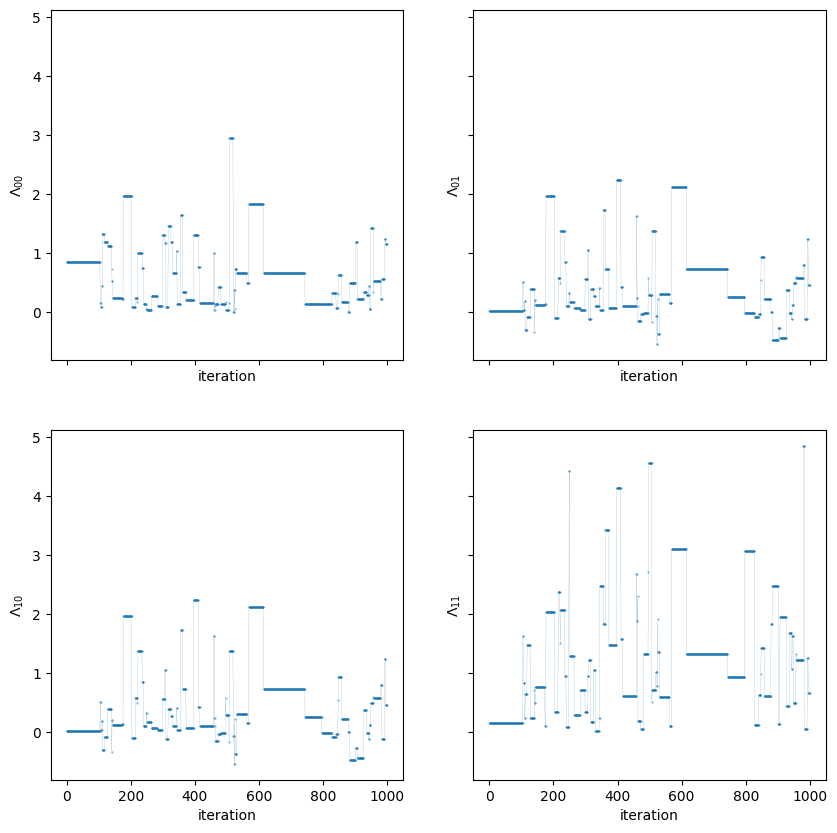

In [29]:
fig, axes = plt.subplots(n, n, figsize=(10, 10), sharex=True, sharey=True)
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        ax.plot(np.arange(0,len(samples),1),samples_merged[i,j],linewidth=0.1, marker='o', markersize=.3)
        ax.set_xlabel(r"iteration")
        ax.set_ylabel(r"$\Lambda_{%d%d}$"%(i,j))
        #ax.set_title(r"Samples from $p(\mathbf{\Lambda}|\mathbf{V},k) $")

In [30]:
samples_mean

array([[0.64069438, 0.42005024],
       [0.42005024, 1.23464949]])

In [31]:
samples[-1].numpy()

array([[1.14702922, 0.45035585],
       [0.45035585, 0.65483397]])

In [33]:
3 * V

array([[1.50155791, 2.12223113],
       [2.12223113, 4.09176762]])

In [452]:
def compute_wishart_variance(df, scale):
    var = np.empty(shape=(scale.shape[0], scale.shape[0]))
    for i in range(scale.shape[0]):
        for j in range(scale.shape[0]):
            var[i,j] = df * (scale[i,j]**2 + scale[i,i]*scale[j,j])
    return var
compute_wishart_variance(K, V)

array([[1.13070206, 0.69425861],
       [0.69425861, 0.59623919]])

In [453]:
samples_var

array([[0.40700796, 0.24231767],
       [0.24231767, 0.22118318]])

In [454]:
samples_wishart_var

array([[1.15576731, 0.70383976],
       [0.70383976, 0.59990445]])

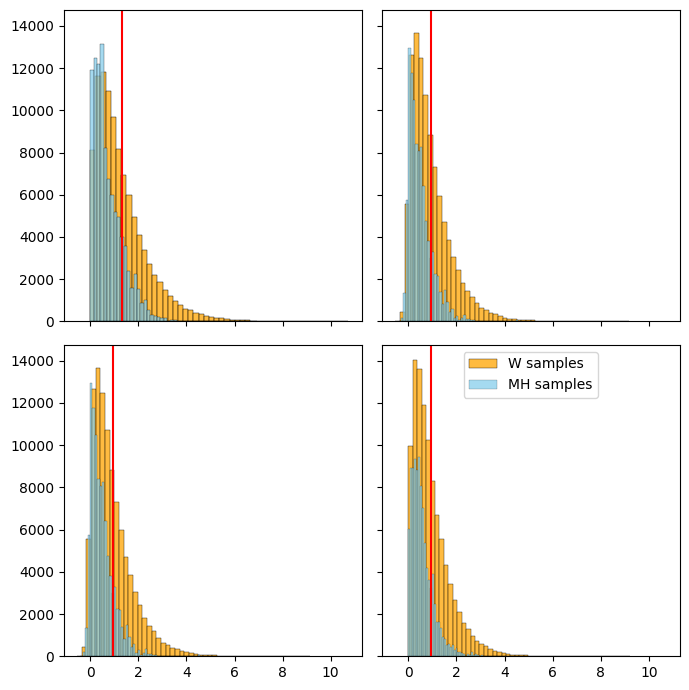

In [455]:
fig, axes = plt.subplots(n, n, figsize=(7, 7), sharex=True, sharey=True)
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        sns.histplot(samples_wishart_merged[i, j], ax=ax, bins=50, kde=False, color='orange', label='W samples')
        sns.histplot(samples_merged[i, j], ax=ax, bins=50, kde=False, color='skyblue', label='MH samples')
        ax.axvline(samples_wishart_mean[i,j], color='red')
        #ax.set_xlim(glob_min-1e-3, glob_max+1e-3)
        ax.set_xlabel('')
        ax.set_ylabel('')
#fig.suptitle('Marginal Wishart values')
plt.legend(loc='upper center')
fig.tight_layout()
plt.show()

# Using the Commutation Matrix

In [219]:
def commutation_matrix(m, n):
    w = np.arange(m * n).reshape((m, n), order="F").T.ravel(order="F")
    return np.eye(m * n)[w, :]
Kc = commutation_matrix(n,n)
print('Commutation matrix: \n', Kc)

Commutation matrix: 
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [122]:
def compute_wishart_mean(df, scale):
    return df * scale
def compute_wishart_variance(df, scale):
    var = np.empty(shape=(scale.shape[0], scale.shape[0]))
    for i in range(scale.shape[0]):
        for j in range(scale.shape[0]):
            var[i,j] = df * (scale[i,j]**2 + scale[i,i]*scale[j,j])
    return var
print('Wishart mean: \n',compute_wishart_variance(K, V)) 
print('Wishart variance: \n',compute_wishart_mean(K, V))

Wishart mean: 
 [[4. 2.]
 [2. 4.]]
Wishart variance: 
 [[2. 0.]
 [0. 2.]]


In [220]:
def jacobian(Kc, L, n):
    J = (Kc + np.eye(Kc.shape[0])) @ np.kron(L, np.eye(n))
    return np.abs(np.linalg.det(J))

In [152]:
commutation_matrix(2,2)

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [206]:
#L = np.array([[1,0],[0.5,1]])
L = np.random.rand(2,2)
Linv = np.linalg.inv(L)
LTinv = np.linalg.inv(L.T)
M = LTinv @ L @ L.T @ Linv

In [190]:
L @ L.T

array([[0.28635749, 0.1132568 ],
       [0.1132568 , 0.32820968]])

In [191]:
L.T @ M @ L

array([[0.28635749, 0.1132568 ],
       [0.1132568 , 0.32820968]])

In [167]:
L @ Linv

array([[1., 0.],
       [0., 1.]])

In [200]:
L = np.random.rand(2,2)
#L = np.array([[1,0],[0.5,1]])
I = np.eye(L.shape[0])
Kc = commutation_matrix(L.shape[0],L.shape[0])
Linv = np.linalg.inv(L)
LTinv = np.linalg.inv(L.T)
M = LTinv @ L @ L.T @ Linv
J = np.kron(L.T @ M.T, I) @ Kc + np.kron(I, L.T @ M)
J
#jacobian(Kc, L, 2)

array([[-26.29840575,  10.03485306,   0.        ,   0.        ],
       [-35.90402415,  13.6993919 , -13.14920287,   5.01742653],
       [-35.90402415,  13.6993919 , -13.14920287,   5.01742653],
       [  0.        ,   0.        , -71.80804829,  27.39878379]])

In [4]:
def rw_mh_step(Ls_prev_array, step_size, scale, K, jacobian=False, thinning=2, burn_in=100):
    # Sample L from a Gaussian distribution
    Ls_tilde_array = np.random.multivariate_normal(mean=np.zeros(len(Ls_prev_array)), cov=np.eye(len(Ls_prev_array))) 
    Ls_tilde = Ls_tilde_array * step_size + Ls_prev_array
    # Reshape Ls_tilde and Ls_prev into lower triangular matrices
    Ls_tilde = tfp.math.fill_triangular(Ls_tilde_array)
    Ls_prev = tfp.math.fill_triangular(Ls_prev_array)
    # Compute precision matrices
    Ps_tilde = Ls_tilde @ tf.transpose(Ls_tilde)
    Ps_prev = Ls_prev @ tf.transpose(Ls_prev)
    # Compute acceptance ratio
    if jacobian == False:
        log_gs = scipy.stats.wishart.logpdf(Ps_tilde, df=K, scale=scale)
        log_gs1 = scipy.stats.wishart.logpdf(Ps_prev, df=K, scale=scale)
    else:
        log_gs = scipy.stats.wishart.logpdf(Ps_tilde, df=K, scale=scale)  
        log_gs1 = scipy.stats.wishart.logpdf(Ps_prev, df=K, scale=scale)
    log_ps1 = scipy.stats.multivariate_normal.logpdf(Ls_prev_array, mean=Ls_tilde_array, cov=np.eye(len(Ls_tilde_array)))
    log_ps = scipy.stats.multivariate_normal.logpdf(Ls_tilde_array, mean=Ls_prev_array, cov=np.eye(len(Ls_tilde_array)))
    log_ratio = (log_gs - log_gs1) + (log_ps1 - log_ps)
    ratio = np.exp(log_ratio)
    if ratio >= 1 or ratio >= np.random.uniform(0, 1):
        if np.random.randint(0, thinning) == 0 and burn_in <= 0:
            return Ls_tilde
        else:
            return Ls_prev
    else:
        return Ls_prev

In [5]:
def run_sampling(Ls_prev_array, n_samples, step_size, scale, K):
    samples = []
    for _ in range(n_samples):
        Ls = rw_mh_step(Ls_prev_array, step_size, scale, K)
        samples.append(Ls @ tf.transpose(Ls))
    return samples

In [7]:
n = 2
n_samples = 100000
size = int(n*(n+1)/2)
step_size = 0.1
V = np.random.rand(n)#np.eye(n)
K = 3
Ls_prev_array = np.ones(size)
samples = run_sampling(Ls_prev_array, n_samples, 0.5, V, K)
samples_wishart = scipy.stats.wishart.rvs(df=K, scale=V, size=n_samples)

In [10]:
len(samples)

100000

In [8]:
samples_merged = np.empty((n, n), dtype=object)
samples_wishart_merged = np.empty((n, n), dtype=object)
samples_mean = np.empty((n, n))
samples_var = np.empty((n, n))
for i in range(n):
    for j in range(n):
        samples_merged[i,j] = [mat[i, j].numpy() for mat in samples]
        samples_wishart_merged[i,j] = [mat[i, j] for mat in samples_wishart]
        samples_mean[i,j] = np.mean(samples_merged[i, j])
        samples_var[i,j] = np.var(samples_merged[i, j])

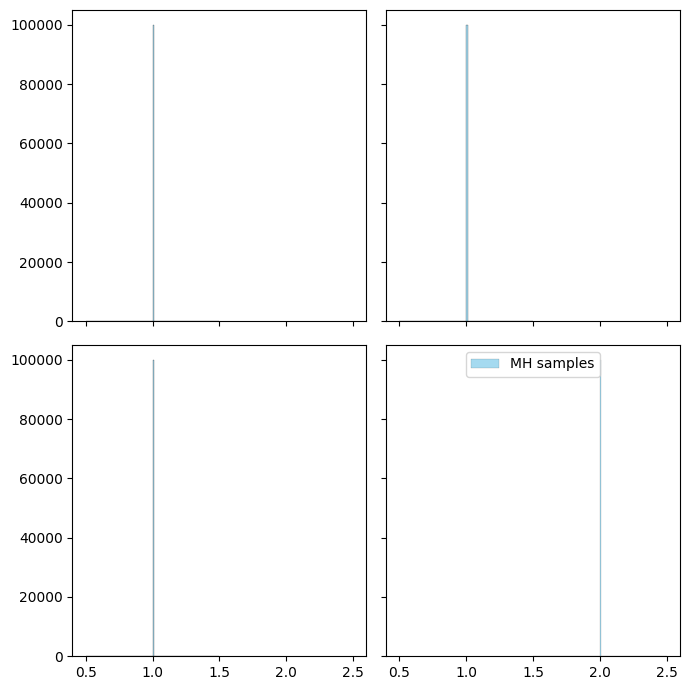

In [11]:
fig, axes = plt.subplots(n, n, figsize=(7, 7), sharex=True, sharey=True)
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        #sns.histplot(samples_wishart_merged[i, j], ax=ax, bins=100, kde=False, color='orange', label='W samples')
        sns.histplot(samples_merged[i, j], ax=ax, bins=100, kde=False, color='skyblue', label='MH samples')
        #ax.axvline(samples_mean[i,j], color='red')
        #ax.set_xlim(glob_min-1e-3, glob_max+1e-3)
        ax.set_xlabel('')
        ax.set_ylabel('')
#fig.suptitle('Marginal Wishart values')
plt.legend(loc='upper center')
fig.tight_layout()
plt.show()

In [150]:
np.kron(np.random.rand(2,2), np.eye(2))

array([[0.07173606, 0.        , 0.05997363, 0.        ],
       [0.        , 0.07173606, 0.        , 0.05997363],
       [0.80997414, 0.        , 0.21379413, 0.        ],
       [0.        , 0.80997414, 0.        , 0.21379413]])

In [36]:
def plot_ellipse(df, scale, n_samples=1):
    for _ in range(n_samples):
        eigenvalues, eigenvectors = np.linalg.eig(scipy.stats.wishart.rvs(df=df, scale=scale, size=1))
        major_axis = 2 * np.sqrt(eigenvalues[0]) * eigenvectors[:, 0]
        minor_axis = 2 * np.sqrt(eigenvalues[1]) * eigenvectors[:, 1]
        theta = np.linspace(0, 2*np.pi, 100)
        ellipse_x = np.cos(theta)[:, np.newaxis] * major_axis[0] + np.sin(theta)[:, np.newaxis] * minor_axis[0]
        ellipse_y = np.cos(theta)[:, np.newaxis] * major_axis[1] + np.sin(theta)[:, np.newaxis] * minor_axis[1]
        plt.plot(ellipse_x, ellipse_y, color='b')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

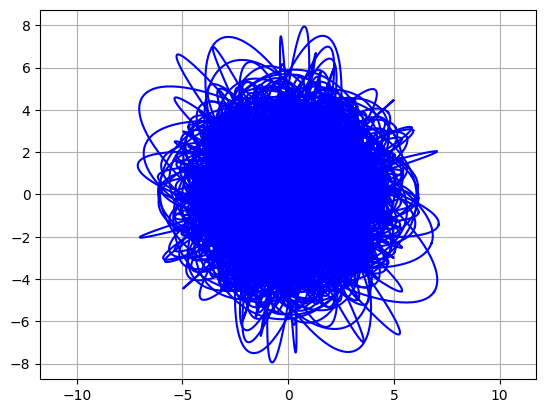

In [38]:
plot_ellipse(df=K, scale=V, n_samples=1000)